In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'Masters_Project/data_processing'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# Load triggers data

import numpy as np 
from sklearn.model_selection import train_test_split

triggers = np.load("./triggers_data.npz")

Xraw = []
yraw = []
for i, key in enumerate(triggers):
    sig = triggers[key]
    Xraw.append(sig)
    yraw.append(np.full(len(sig), i))

Xraw = np.concatenate(Xraw)
yraw = np.concatenate(yraw)
Xraw.shape

(177, 30)

In [3]:
# Split data into test  and train set
Xtrain, Xtest, ytrain, ytest = train_test_split(Xraw, yraw, test_size=0.1, random_state=42)
print("Fraction of single class in test set: ", np.mean(ytest==0))
print("Size of test set:", Xtest.shape)

# Split train data into train and validation set
Xfold, Xval, yfold, yval = train_test_split(Xtrain, ytrain, test_size=0.1, random_state=42)
print("Size of train set:", Xtrain.shape)

Fraction of single class in test set:  0.5
Size of test set: (18, 30)
Size of train set: (159, 30)


In [4]:
# Function to print accuracy of validation set while training
def checkAcc(x, y, model):
    scores = model(x)
    _, preds = scores.max(1)
    num_correct = (preds == y).sum()
    num_samples = preds.size(0)
    acc = float(num_correct) / num_samples
    print(f"Accuracy: {num_correct} / {num_samples} = {acc:.2f}")

In [13]:
# Try to code a simple network
import torch

device = torch.device('cpu')
dtype = torch.float32

N, D_in, H, D_out = len(Xtrain), 30, 1000, 2 

# Create random Tensors to hold inputs and outputs
x = torch.tensor(Xfold, device=device, dtype=dtype)
y = torch.tensor(yfold, device=device, dtype=torch.long)

xv = torch.tensor(Xval, device=device, dtype=dtype)
yv = torch.tensor(yval, device=device, dtype=torch.long)


# Use nn.Sequention API 
# Each layer has its own internal weights and bias 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        ).to(device)

# Loss function to use - check available functions on pytorch
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
for t in range(1000):

    y_pred = model(x)

    loss = loss_fn(y_pred, y)

    if t%100==0:
      print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # Internally, this call will compute gradients for all learnable parameters in the model.
    loss.backward()

    # Update weights
    with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
        for param in model.parameters():
          param.data -= learning_rate * param.grad
    
        if t%100==0:
            checkAcc(xv, yv, model)

0 0.6999168395996094
Accuracy: 7 / 16 = 0.44
100 0.676041841506958
Accuracy: 12 / 16 = 0.75
200 0.6723834872245789
Accuracy: 12 / 16 = 0.75
300 0.6688294410705566
Accuracy: 12 / 16 = 0.75
400 0.6653404235839844
Accuracy: 14 / 16 = 0.88
500 0.6619263887405396
Accuracy: 14 / 16 = 0.88
600 0.6585984826087952
Accuracy: 14 / 16 = 0.88
700 0.6553627252578735
Accuracy: 14 / 16 = 0.88
800 0.652204155921936
Accuracy: 14 / 16 = 0.88
900 0.6491347551345825
Accuracy: 14 / 16 = 0.88


In [14]:
# Test model on test data
xt= torch.tensor(Xtest, device=device, dtype=dtype)
yt= torch.tensor(ytest, device=device, dtype=torch.long)

checkAcc(xt, yt, model)

Accuracy: 13 / 18 = 0.72


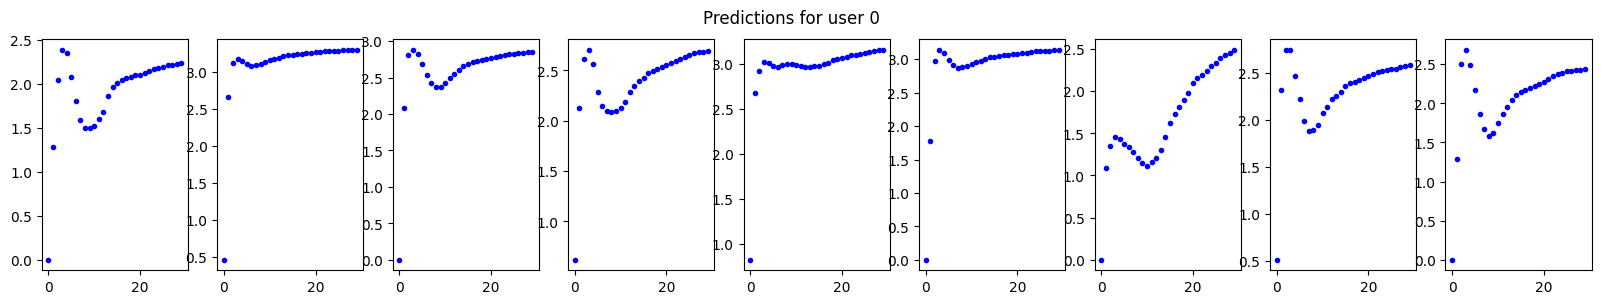

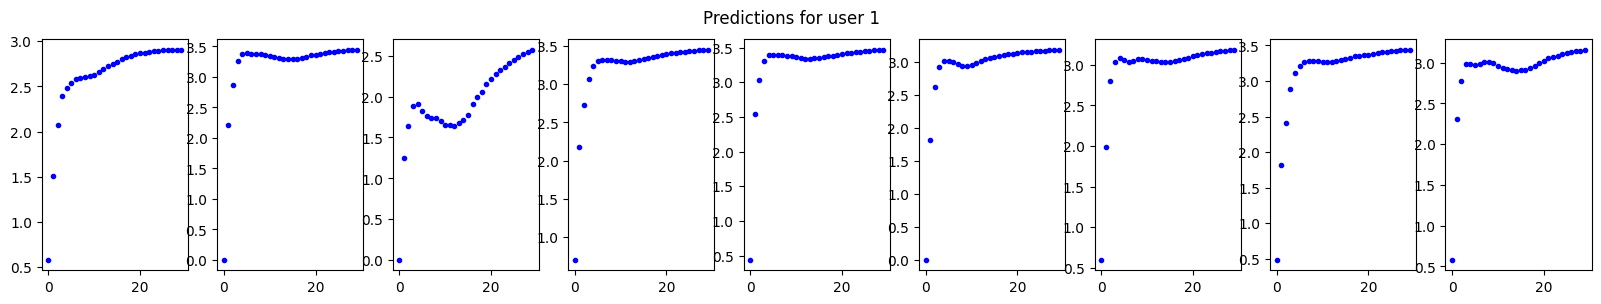

In [12]:
import matplotlib.pyplot as plt
# Plot results
with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
    scores = model(xt)
    _, preds = scores.max(1)

predictions = preds.numpy()

usr1 = predictions==0
usr2 = ~usr1

for j, usr in enumerate([usr1, usr2]):
    X1 = Xtest[usr]
    plt.figure(figsize=(20, 3))
    plt.suptitle(f"Predictions for user {j}")
    for i, x in enumerate(X1):
        plt.subplot(1, len(X1), i+1)
        plt.plot(range(len(x)), x, "b.")